## Neural machine translation: English-to-Spanish

- Approach: sequence-to-sequence models (encoder -> thought vector -> decoder) with teacher forcing
- Detail: 
  - one LSTM in encoder 
  - output the last state which serves as the initial input of states for 2nd LSTM in decoder 
  - since using teacher forcing, two different LSTMS are build for training and prediction seperately:
    - training LSTM takes in sequence of length max_sequence_length
    - prediction LSTM takes in sequence of lenghth 1 (previous word)
- Result: Using Google translate to test the translation accuracy, it's found that the sequence to sequence model I used here is not very accuracy, however, due to the time and computation resource limit, the training only ran for 10 epochs on 10000 samples. Increasing epochs and training dataset will increase the translation accuracy. 

In [2]:
# Disable warnings
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.utils import to_categorical
import keras.backend as K

In [4]:
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU

In [5]:
# configuration
batch_size = 64
epochs = 10
latent_dim = 256 
num_samples = 10000 # number of samples to be trained
max_sequence_length = 100
max_num_words = 20000
embedding_dim = 100 # embedding dimension

In [6]:
# load in data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language + <'eos>
target_texts_inputs = [] # <'sos'> + sentence in target language 


t = 0
for line in open('../large_files/translation/spa.txt'):
    t += 1
    if t > num_samples:
        break

    # input and target are separated by tab
    if '\t' not in line:
        continue

    input_text, translation = line.rstrip().split('\t')

    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation

    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
    
print("num samples:", len(input_texts))

num samples: 10000


In [7]:
print(type(input_texts))
print("Englisth: ", input_texts[20:40])
print("Spanish: ", target_texts[20:40])

<class 'list'>
Englisth:  ['Wait.', 'Go on.', 'Go on.', 'Hello!', 'I ran.', 'I ran.', 'I try.', 'I won!', 'Oh no!', 'Relax.', 'Smile.', 'Attack!', 'Attack!', 'Get up.', 'Go now.', 'Got it!', 'Got it?', 'Got it?', 'He ran.', 'Hop in.']
Spanish:  ['Esperen. <eos>', 'Continúa. <eos>', 'Continúe. <eos>', 'Hola. <eos>', 'Corrí. <eos>', 'Corría. <eos>', 'Lo intento. <eos>', '¡He ganado! <eos>', '¡Oh, no! <eos>', 'Tomátelo con soda. <eos>', 'Sonríe. <eos>', '¡Al ataque! <eos>', '¡Atacad! <eos>', 'Levanta. <eos>', 'Ve ahora mismo. <eos>', '¡Lo tengo! <eos>', '¿Lo pillas? <eos>', '¿Entendiste? <eos>', 'Él corrió. <eos>', 'Métete adentro. <eos>']


### Model buiding and training

In [8]:
# Since two languages, need 2 different tokenizers
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=max_num_words)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)
# word to index mapping
word2idx_inputs = tokenizer_inputs.word_index
print("number of unique input tokens: ", len(word2idx_inputs))
# maximum sequence length for inputs
max_len_input = max(len(s) for s in input_sequences)

number of unique input tokens:  2367


In [9]:
# tokenize the outputs
tokenizer_outputs = Tokenizer(num_words=max_num_words, filters='')
# with filters = '': do not filter out special characters like <sos>, <eos>
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) 
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)
# word to index mapping
word2idx_outputs = tokenizer_outputs.word_index
print("number of unique output tokens: ", len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_len_target = max(len(s) for s in target_sequences)

number of unique output tokens:  6325


In [10]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape: ", encoder_inputs.shape)
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs.shape: ", decoder_inputs.shape)
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape:  (10000, 5)
decoder_inputs.shape:  (10000, 9)


In [11]:
# prepare word embedding using pre-trained glove
word2vec = {}
with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % embedding_dim)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

In [12]:
# word embedding matrix for inputs
num_words = min(max_num_words, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word2idx_inputs.items():
    if i < max_num_words:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

In [13]:
# create embedding layer
embedding_layer = Embedding(
    num_words,
    embedding_dim,
    weights = [embedding_matrix],
    input_length = max_len_input,
    trainable = False
)

In [14]:
# one-hot-encoding targets
# sparse_... loss without one-hot encoding does not work on sequence format target
decoder_targets_one_hot = np.zeros(
    (
      len(input_texts),
      max_len_target,
      num_words_output
    ),
    dtype='float32'
)
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [15]:
# build the model
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  latent_dim,
  return_state=True,
  dropout=0.5 # dropout not available on gpu
)
encoder_outputs, h, c = encoder(x)
# encoder_output, h = encoder(x) # for GRU

encoder_states = [h, c]
# encoder_states = [h] # GRU

# set up decoder using [h,c] as initial state
decoder_inputs_placeholder = Input(shape=(max_len_target,))
# word embedding for targets will not use pre-trainined glove, although we can
decoder_embedding = Embedding(num_words_output, latent_dim)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(
    latent_dim,
    return_sequences=True,
    return_state=True,
    dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)
# dense layer
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 138s 17ms/step - loss: 2.6828 - acc: 0.6511 - val_loss: 2.6401 - val_acc: 0.6561
Epoch 2/10
8000/8000 [==============================] - 137s 17ms/step - loss: 2.0598 - acc: 0.7119 - val_loss: 2.4546 - val_acc: 0.6688
Epoch 3/10
8000/8000 [==============================] - 137s 17ms/step - loss: 1.8700 - acc: 0.7273 - val_loss: 2.3328 - val_acc: 0.6812
Epoch 4/10
8000/8000 [==============================] - 136s 17ms/step - loss: 1.7448 - acc: 0.7380 - val_loss: 2.2505 - val_acc: 0.6933
Epoch 5/10
8000/8000 [==============================] - 136s 17ms/step - loss: 1.6367 - acc: 0.7478 - val_loss: 2.1988 - val_acc: 0.7016
Epoch 6/10
8000/8000 [==============================] - 140s 17ms/step - loss: 1.5402 - acc: 0.7580 - val_loss: 2.1496 - val_acc: 0.7101
Epoch 7/10
8000/8000 [==============================] - 143s 18ms/step - loss: 1.4596 - acc: 0.7669 - val_loss: 2.1451 - val_acc: 

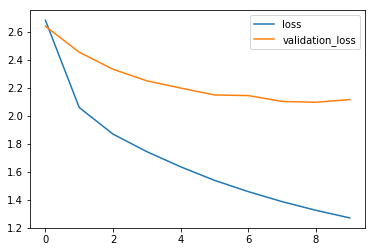

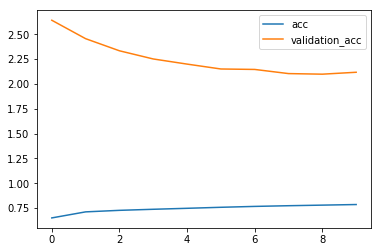

In [16]:
r = model.fit(
    [encoder_inputs, decoder_inputs], 
    decoder_targets_one_hot,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = 0.2,
)

plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'validation_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label = 'acc')
plt.plot(r.history['val_loss'], label = 'validation_acc')
plt.legend()
plt.show()

model.save('s2s.h5')

### Make predictions

In [17]:
# Create another model that takes in previous word and state as input and accept a lenghth one sequence (T = 1)
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

# map index back into real words
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [20]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    
    # if get index for <eos>, break
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_len_target):  
        output_tokens, h, c = decoder_model.predict(
          [target_seq] + states_value
        )
        # output_tokens, h = decoder_model.predict(
        #     [target_seq] + states_value
        # ) # GRU

        # idx for next word
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        # Update the decoder input
        target_seq[0, 0] = idx
        # Update states
        states_value = [h, c]
        # states_value = [h] # GRU
    
    return ' '.join(output_sentence)

In [21]:
while True:
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: I have no money.
Translation: tengo que que tengo que sí.
Continue? [Y/n]Y
-
Input: That's wet.
Translation: está frío.
Continue? [Y/n]Y
-
Input: Are you American?
Translation: ¿estás en casa?
Continue? [Y/n]Y
-
Input: She's pregnant.
Translation: estoy borracho.
Continue? [Y/n]Y
-
Input: I'd buy that.
Translation: no lo eso.
Continue? [Y/n]Y
-
Input: You're my enemy.
Translation: es mi libro.
Continue? [Y/n]Y
-
Input: This is no good.
Translation: esto es una libro.
Continue? [Y/n]Y
-
Input: I said goodbye.
Translation: yo me sentía enfermo.
Continue? [Y/n]Y
-
Input: Which side won?
Translation: se ha ha casa.
Continue? [Y/n]Y
-
Input: Come with us.
Translation: ven y poco.
Continue? [Y/n]Y
-
Input: They're alive.
Translation: estoy en de de tom.
Continue? [Y/n]Y
-
Input: Tom is perfect.
Translation: tom es un libro.
Continue? [Y/n]Y
-
Input: I like climbing.
Translation: me gusta el perros.
Continue? [Y/n]N
